# Importing Packages/Libraries

In [1]:
!pip install --quiet scikit-learn pandas numpy matplotlib seaborn psutil openpyxl tqdm
import os
import io
import time
import math
import psutil
import zipfile
import requests
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

# Loading the DataSets

In [2]:
from google.colab import files

def download_to_df(url, read_func='csv', **kwargs):
    """
    Try to download from url and read into pandas DataFrame.
    read_func: 'csv' or 'excel' or 'zip_csv'
    """
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        content = r.content
        if read_func == 'csv':
            return pd.read_csv(io.BytesIO(content), **kwargs)
        elif read_func == 'excel':
            return pd.read_excel(io.BytesIO(content), **kwargs)
        elif read_func == 'zip_csv':
            z = zipfile.ZipFile(io.BytesIO(content))
            # pick first csv file
            for name in z.namelist():
                if name.lower().endswith('.csv'):
                    return pd.read_csv(z.open(name), **kwargs)
            raise RuntimeError("No CSV inside ZIP")
        else:
            raise ValueError("read_func unknown")
    except Exception as e:
        print(f"Could not download from {url} (error: {e}).\nPlease upload the file manually (click to choose file).")
        uploaded = files.upload()
        # take the first uploaded file
        fn = list(uploaded.keys())[0]
        if fn.lower().endswith(('.xls', '.xlsx')):
            return pd.read_excel(fn, **kwargs)
        else:
            return pd.read_csv(fn, **kwargs)

def load_classification_datasets():
    """
    Returns a dict: name -> (X, y, feature_names)
    Classification datasets:
    - Breast Cancer Wisconsin (Diagnostic)   (UCI / sklearn)
    - Heart Disease (Cleveland)              (UCI)
    - MAGIC Gamma Telescope                  (UCI)
    - Rice (Cammeo and Osmancik)             (UCI / author)
    """
    datasets = {}

    # Breast Cancer
    from sklearn.datasets import load_breast_cancer
    bc = load_breast_cancer(as_frame=True)
    X = bc.data.values
    y = bc.target.values
    datasets["BreastCancer_Diagnostic"] = (X, y, bc.feature_names.tolist())

    # Heart Disease (Cleveland)
    heart_df = None
    if heart_df is None:
        heart_df = download_to_df("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None)
    heart_df = heart_df.replace("?", np.nan)
    heart_df = heart_df.dropna()
    if 'target' in heart_df.columns:
        y = heart_df['target'].values
        X = heart_df.drop(columns=['target']).values
        feature_names = [c for c in heart_df.columns if c != 'target']
    else:
        X = heart_df.iloc[:, :-1].values
        y = heart_df.iloc[:, -1].values
        feature_names = heart_df.columns[:-1].tolist()
    X = X.astype(float)
    datasets["HeartDisease_Cleveland"] = (X, y, feature_names)

    # MAGIC Gamma Telescope
    magic_urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"
    ]
    magic_df = None
    for u in magic_urls:
        try:
            magic_df = download_to_df(u, header=None)
            break
        except:
            magic_df = None
    if magic_df.shape[1] > 0:
        y_raw = magic_df.iloc[:, -1].values
        X = magic_df.iloc[:, :-1].values
        if np.issubdtype(y_raw.dtype, np.number):
            y = y_raw.astype(int)
        else:
            y = np.array([1 if str(v).strip().lower().startswith('g') else 0 for v in y_raw])
    else:
        raise RuntimeError("MAGIC dataset read error")
    datasets["MAGIC_GammaTelescope"] = (X, y, [f"f{i}" for i in range(X.shape[1])])

    # Rice (Cammeo and Osmancik)
    rice_urls = [
        "https://raw.githubusercontent.com/muratkoklu/datasets/master/rice_dataset.csv"
    ]
    rice_df = None
    for u in rice_urls:
        try:
            rice_df = download_to_df(u)
            break
        except:
            rice_df = None
    if "Class" not in rice_df.columns:
      raise ValueError("Uploaded Rice dataset must contain a 'Class' column.")

    rice_df["Class"] = rice_df["Class"].map({
        "Cammeo": 0,
        "Osmancik": 1,
        "cammeo": 0,
        "osmancik": 1
    })
    if rice_df["Class"].isna().any():
      print("Warning: Some class labels were not recognized. Unique values:")
      print(rice_df["Class"].unique())
      raise ValueError("Fix class labels in the CSV.")

    X = rice_df.drop(columns=["Class"]).values
    y = rice_df["Class"].values
    feature_names = rice_df.drop(columns=["Class"]).columns.tolist()

    datasets["Rice_Cammeo_Osmancik"] = (X, y, feature_names)
    return datasets

def load_regression_datasets():
    """
    Returns a dict: name -> (X, y, feature_names)
    Regression datasets requested:
    - Abalone (4177 x 8)         -> UCI
    - Air Quality (9358 x 15)    -> UCI
    - Appliances Energy (19735 x 28) -> UCI
    - Concrete Compressive Strength (1030 x 8) -> UCI
    - Wine Quality (4898 x 11)   -> UCI (red+white or combined)
    """
    datasets = {}

    # Abalone
    abalone_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
    ab_cols = ["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]
    ab_df = download_to_df(abalone_url, header=None, names=ab_cols)
    le = LabelEncoder()
    ab_df["Sex"] = le.fit_transform(ab_df["Sex"])
    # Usually target is Rings; use Rings
    X = ab_df.iloc[:, :-1].values
    y = ab_df['Rings'].values
    datasets["Abalone"] = (X, y, ab_cols[:-1])

    # Air Quality (AirQualityUCI)
    air_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    try:
        # special read: inside zip there's AirQualityUCI.csv (semicolon sep)
        r = requests.get(air_url, timeout=30)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        # look for .csv or .txt
        fn = None
        for name in z.namelist():
            if name.lower().endswith('.csv') or name.lower().endswith('.txt'):
                fn = name
                break
        air_df = pd.read_csv(z.open(fn), sep=';', decimal=',')
        # drop last two empty cols if present
        air_df = air_df.loc[:, ~air_df.columns.str.contains('^Unnamed')]
        # choose all numeric columns; drop NaN-only rows
        numeric = air_df.select_dtypes(include=[np.number]).dropna(axis=0, how='all')
        numeric = numeric.dropna(axis=0)  # drop rows with NaNs
        X = numeric.iloc[:, :-1].values
        y = numeric.iloc[:, -1].values
        datasets["AirQuality"] = (X, y, numeric.columns[:-1].tolist())
    except Exception as e:
        print("AirQuality automatic download failed:", e)
        # fallback: ask user upload
        df = download_to_df("https://raw.githubusercontent.com/odoe/air-quality/master/AirQualityUCI.csv")
        X = df.select_dtypes(include=[np.number]).iloc[:, :-1].dropna().values
        y = df.select_dtypes(include=[np.number]).iloc[:, -1].dropna().values
        datasets["AirQuality"] = (X, y, df.select_dtypes(include=[np.number]).columns[:-1].tolist())

    # Appliances Energy Prediction
    ap_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
    ap_df = None
    try:
        ap_df = download_to_df(ap_url)
    except:
        print("Appliances dataset failed to download automatically; please upload CSV.")
        ap_df = download_to_df(ap_url)

    if "date" in ap_df.columns:
      ap_df = ap_df.drop(columns=["date"])
    # target: 'Appliances'
    if 'Appliances' in ap_df.columns:
        y = ap_df['Appliances'].values
        X = ap_df.drop(columns=['Appliances']).values
        fnames = ap_df.drop(columns=['Appliances']).columns.tolist()
    else:
        X = ap_df.iloc[:, :-1].values
        y = ap_df.iloc[:, -1].values
        fnames = ap_df.columns[:-1].tolist()
    datasets["AppliancesEnergy"] = (X, y, fnames)

    # Concrete Compressive Strength
    concrete_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    concrete_df = download_to_df(concrete_url, read_func='excel')
    # last column is Concrete compressive strength (MPa)
    X = concrete_df.iloc[:, :-1].values
    y = concrete_df.iloc[:, -1].values
    datasets["Concrete_CompressiveStrength"] = (X, y, concrete_df.columns[:-1].tolist())


    # Wine Quality
    wine_urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    ]
    wine_df = None
    for u in wine_urls:
        try:
            wine_df = download_to_df(u, sep=';')
            break
        except:
            wine_df = None
    if wine_df is None:
        wine_df = download_to_df(wine_urls[0], sep=';')
    X = wine_df.iloc[:, :-1].values
    y = wine_df.iloc[:, -1].values
    datasets["WineQuality"] = (X, y, wine_df.columns[:-1].tolist())

    return datasets


In [3]:
print("Loading classification datasets...")
class_dsets = load_classification_datasets()
print("Loading regression datasets...")
reg_dsets = load_regression_datasets()
print("\nDatasets loaded:")
for k in list(class_dsets.keys()) + list(reg_dsets.keys()):
    print("-", k)

Loading classification datasets...
Could not download from https://raw.githubusercontent.com/muratkoklu/datasets/master/rice_dataset.csv (error: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/muratkoklu/datasets/master/rice_dataset.csv).
Please upload the file manually (click to choose file).


Saving Rice_Cammeo_Osmancik.xlsx to Rice_Cammeo_Osmancik (1).xlsx
Loading regression datasets...

Datasets loaded:
- BreastCancer_Diagnostic
- HeartDisease_Cleveland
- MAGIC_GammaTelescope
- Rice_Cammeo_Osmancik
- Abalone
- AirQuality
- AppliancesEnergy
- Concrete_CompressiveStrength
- WineQuality


# Feture Scaling Functions

In [4]:

import numpy as np

def no_scale(X):
    return np.array(X, dtype=float)
def minmax_scaler(X):
    X = np.array(X, dtype=float)
    Xmin = np.nanmin(X, axis=0)
    Xmax = np.nanmax(X, axis=0)
    denom = (Xmax - Xmin)
    denom[denom == 0] = 1.0
    return (X - Xmin) / denom

def max_abs_scaler(X):
    X = np.array(X, dtype=float)
    maxabs = np.nanmax(np.abs(X), axis=0)
    maxabs[maxabs == 0] = 1.0
    return X / maxabs

def zscore_scaler(X):
    X = np.array(X, dtype=float)
    mu = np.nanmean(X, axis=0)
    sigma = np.nanstd(X, axis=0, ddof=0)
    sigma[sigma == 0] = 1.0
    return (X - mu) / sigma

def vast_scaler(X):
    # Variable Stability Scaling:
    # Xnorm = ((X - mu) / sigma) * (mu / sigma)
    X = np.array(X, dtype=float)
    mu = np.nanmean(X, axis=0)
    sigma = np.nanstd(X, axis=0, ddof=0)
    sigma_adj = sigma.copy()
    sigma_adj[sigma_adj == 0] = 1.0
    factor = mu / sigma_adj
    return ((X - mu) / sigma_adj) * factor

def pareto_scaler(X):
    # Pareto: (X - mu) / sqrt(std)
    X = np.array(X, dtype=float)
    mu = np.nanmean(X, axis=0)
    sigma = np.nanstd(X, axis=0, ddof=0)
    sigma_adj = sigma.copy()
    sigma_adj[sigma_adj == 0] = 1.0
    sqrt_sigma = np.sqrt(sigma_adj)
    sqrt_sigma[sqrt_sigma == 0] = 1.0
    return (X - mu) / sqrt_sigma

def robust_scaler(X):
    X = np.array(X, dtype=float)
    med = np.nanmedian(X, axis=0)
    q75 = np.nanpercentile(X, 75, axis=0)
    q25 = np.nanpercentile(X, 25, axis=0)
    iqr = q75 - q25
    iqr[iqr == 0] = 1.0
    return (X - med) / iqr

SCALERS = {
    "NO": no_scale,
    "MM": minmax_scaler,
    "MA": max_abs_scaler,
    "ZSN": zscore_scaler,
    "VAST": vast_scaler,
    "PS": pareto_scaler,
    "RS": robust_scaler
}


# Linear Models

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

def make_regressor(kind, random_state=42):
    if kind == "linear":
        return LinearRegression()

    elif kind == "ridge":
        return Ridge(alpha=1.0, random_state=random_state)

    elif kind == "lasso":
        return Lasso(alpha=0.001, random_state=random_state, max_iter=10000)
    elif kind == "linear_svr":
        return LinearSVR(C=1.0, epsilon=0.0,max_iter=10000, random_state=random_state)
    else:
        raise ValueError(f"Unknown regressor type: {kind}")


In [6]:

def make_classifier(kind, random_state=42):
    # kind: "logistic", "linear_svc", "perceptron"
    if kind == "logistic":
        return SGDClassifier(loss='log_loss', max_iter=10000, tol=1e-4, random_state=random_state)
    elif kind == "linear_svc":
        return SGDClassifier(loss='hinge', max_iter=10000, tol=1e-4, random_state=random_state)
    elif kind == "perceptron":
        return SGDClassifier(loss='perceptron', max_iter=10000, tol=1e-4, random_state=random_state, eta0=1, learning_rate="constant", penalty=None)
    else:
        raise ValueError(kind)

# Training and Evaluation Loop

In [7]:
import psutil
process = psutil.Process(os.getpid())
def round4(x):
    if isinstance(x, (int, float)):
        return round(x, 4)
    return x

def train_and_evaluate_regression(X, y, reg_kind, scaler_fn, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    X_train_scaled = scaler_fn(X_train)
    X_test_scaled = scaler_fn(X_test)

    model = make_regressor(reg_kind, random_state=random_state)
    mem_before = process.memory_info().rss
    t0 = time.time()
    model.fit(X_train_scaled, y_train)
    t1 = time.time()
    mem_after = process.memory_info().rss
    time_taken = t1 - t0
    mem_delta = (mem_after - mem_before) / (1024 ** 2)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    metrics = {
        "train_MSE": round(mean_squared_error(y_train, y_train_pred), 4),
        "test_MSE": round(mean_squared_error(y_test, y_test_pred), 4),
        "train_MAE": round(mean_absolute_error(y_train, y_train_pred), 4),
        "test_MAE": round(mean_absolute_error(y_test, y_test_pred), 4),
        "train_R2": round(r2_score(y_train, y_train_pred), 4),
        "test_R2": round(r2_score(y_test, y_test_pred), 4),
        "time_sec": round(time_taken, 4),
        "mem_mb": round(mem_delta, 4),
        "n_iter": getattr(model, "n_iter_", None)
    }
    return metrics

from sklearn.metrics import f1_score

def train_and_evaluate_classification(X, y, clf_kind, scaler_fn, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    X_train_scaled = scaler_fn(X_train)
    X_test_scaled = scaler_fn(X_test)

    model = make_classifier(clf_kind, random_state=random_state)

    mem_before = process.memory_info().rss
    t0 = time.time()
    model.fit(X_train_scaled, y_train)
    t1 = time.time()
    mem_after = process.memory_info().rss

    time_taken = t1 - t0
    mem_delta = (mem_after - mem_before) / (1024 ** 2)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    metrics = {
        "train_acc": round(accuracy_score(y_train, y_train_pred), 4),
        "test_acc": round(accuracy_score(y_test, y_test_pred), 4),
        "train_f1": round(f1_score(y_train, y_train_pred, average="weighted"), 4),
        "test_f1": round(f1_score(y_test, y_test_pred, average="weighted"), 4),
        "time_sec": round(time_taken, 4),
        "mem_mb": round(mem_delta, 4),
        "n_iter": getattr(model, "n_iter_", None)
    }
    return metrics



# Experiments

In [8]:
def run_experiments(class_dsets, reg_dsets, random_state=42, verbose=True):
    rows = []

    reg_kinds = ["linear", "ridge", "lasso", "linear_svr"]
    clf_kinds = ["logistic", "linear_svc", "perceptron"]

# Regression experiments: for each dataset, for each scaler, for each reg-type (linear, ridge, lasso)
    for name, (X, y, fnames) in reg_dsets.items():
        if verbose: print(f"\n--- Regression dataset: {name} ---")
        for scaler_name, scaler_fn in SCALERS.items():
            if verbose: print(f"  scaler: {scaler_name}")
            Xnum = np.array(X, dtype=float)
            for reg_kind in reg_kinds:
                try:
                    metrics = train_and_evaluate_regression(Xnum, y, reg_kind, scaler_fn, random_state=random_state)
                except Exception as e:
                    print(f"    Error for {name} {scaler_name} {reg_kind}: {e}")
                    continue
                row = {
                    "dataset": name,
                    "task": "regression",
                    "model_kind": reg_kind,
                    "scaler": scaler_name
                }
                row.update(metrics)
                rows.append(row)

    for name, (X, y, fnames) in class_dsets.items():
        if verbose: print(f"\n--- Classification dataset: {name} ---")
        # for classification
        Xnum = np.array(X, dtype=float)
        ynum = np.array(y)
        for scaler_name, scaler_fn in SCALERS.items():
            if verbose: print(f"  scaler: {scaler_name}")
            for clf_kind in clf_kinds:
                try:
                    metrics = train_and_evaluate_classification(Xnum, ynum, clf_kind, scaler_fn, random_state=random_state)
                except Exception as e:
                    print(f"    Error for {name} {scaler_name} {clf_kind}: {e}")
                    continue
                row = {
                    "dataset": name,
                    "task": "classification",
                    "model_kind": clf_kind,
                    "scaler": scaler_name
                }
                row.update(metrics)
                rows.append(row)
    results_df = pd.DataFrame(rows)
    return results_df

In [9]:
results = run_experiments(class_dsets, reg_dsets, random_state=42, verbose=True)
results.to_csv("scaling_convergence_experiment_results.csv", index=False)
print("\nResults saved to scaling_convergence_experiment_results.csv")
display(results.head(20))


--- Regression dataset: Abalone ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Regression dataset: AirQuality ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Regression dataset: AppliancesEnergy ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Regression dataset: Concrete_CompressiveStrength ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Regression dataset: WineQuality ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Classification dataset: BreastCancer_Diagnostic ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Classification dataset: HeartDisease_Cleveland ---
  scaler: NO
  scaler: MM
  scaler: MA
  scaler: ZSN
  scaler: VAST
  scaler: PS
  scaler: RS

--- Cl

,dataset,task,model_kind,scaler,train_MSE,test_MSE,train_MAE,test_MAE,train_R2,test_R2,time_sec,mem_mb,n_iter,train_acc,test_acc,train_f1,test_f1
0,Abalone,regression,linear,NO,4.8697,5.0625,1.6037,1.6306,0.5265,0.5323,0.0174,1.0312,NaN,NaN,NaN,NaN,NaN
1,Abalone,regression,ridge,NO,4.9067,5.1056,1.6113,1.6389,0.5229,0.5284,0.0062,0.5898,NaN,NaN,NaN,NaN,NaN
2,Abalone,regression,lasso,NO,4.8753,5.0768,1.6054,1.6350,0.5259,0.5310,0.0581,0.1562,655.0,NaN,NaN,NaN,NaN
3,Abalone,regression,linear_svr,NO,5.4455,5.6306,1.5811,1.5985,0.4705,0.4799,0.0142,0.2148,207.0,NaN,NaN,NaN,NaN
4,Abalone,regression,linear,MM,4.8697,25.8980,1.6037,4.5416,0.5265,-1.3924,0.0077,0.0000,NaN,NaN,NaN,NaN,NaN
5,Abalone,regression,ridge,MM,4.9704,15.8631,1.6187,3.4804,0.5167,-0.4654,0.0053,0.0000,NaN,NaN,NaN,NaN,NaN
6,Abalone,regression,lasso,MM,4.8809,20.5584,1.6061,4.0054,0.5254,-0.8991,0.0449,0.0000,566.0,NaN,NaN,NaN,NaN
7,Abalone,regression,linear_svr,MM,5.6412,8.3235,1.5981,2.4413,0.4515,0.2311,0.0223,0.0000,137.0,NaN,NaN,NaN,NaN
8,Abalone,regression,linear,MA,4.8697,30.6121,1.6037,5.0558,0.5265,-1.8279,0.0397,0.0000,NaN,NaN,NaN,NaN,NaN
9,Abalone,regression,ridge,MA,4.9711,18.6342,1.6188,3.8645,0.5166,-0.7214,0.0268,0.0000,NaN,NaN,NaN,NaN,NaN


# Plotting Results for each DataSet

In [10]:
import os
sns.set(style="whitegrid")

def plot_regression_metrics(df, dataset_name, save_dir="plots"):
    # Create directory if not exists
    os.makedirs(save_dir, exist_ok=True)

    df_ds = df[(df['dataset'] == dataset_name) & (df['task'] == 'regression')]
    if df_ds.empty:
        print("No regression rows for", dataset_name)
        return

    metrics = ['test_MSE', 'test_MAE', 'test_R2']

    for metric in metrics:
        plt.figure(figsize=(10,5))

        sns.barplot(
            data=df_ds,
            x='model_kind',
            y=metric,
            hue='scaler'
        )

        plt.title(f"{dataset_name} - {metric} by model & scaler")
        plt.xlabel("Model")
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend(title="Scaler", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()


        filename = f"{save_dir}/{dataset_name}_{metric}.png"
        plt.savefig(filename, dpi=300)
        print("Saved:", filename)

        plt.show()

    # Convergence Time plot
    plt.figure(figsize=(10,5))

    sns.barplot(
        data=df_ds,
        x='model_kind',
        y='time_sec',
        hue='scaler'
    )

    plt.title(f"{dataset_name} - Convergence Time by model & scaler")
    plt.xlabel("Model")
    plt.ylabel("Time (sec)")
    plt.xticks(rotation=45)
    plt.legend(title="Scaler", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()


    filename = f"{save_dir}/{dataset_name}_convergence_time.png"
    plt.savefig(filename, dpi=300)
    print("Saved:", filename)

    plt.show()


In [11]:
def plot_classification_metrics(df, dataset_name):
    df_ds = df[(df['dataset']==dataset_name) & (df['task']=='classification')]
    if df_ds.empty:
        print("No classification rows for", dataset_name)
        return

    # Accuracy
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_ds,
        x='model_kind',
        y='test_acc',
        hue='scaler'
    )
    plt.title(f"{dataset_name} - Test Accuracy by model & scaler")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.legend(title="Scaler", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"{dataset_name}_classification_accuracy.png", dpi=300)
    plt.close()

    # F1-score
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_ds,
        x='model_kind',
        y='test_f1',
        hue='scaler'
    )
    plt.title(f"{dataset_name} - Test F1 Score by model & scaler")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)
    plt.legend(title="Scaler", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"{dataset_name}_classification_f1.png", dpi=300)
    plt.close()

    # Convergence time
    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_ds,
        x='model_kind',
        y='time_sec',
        hue='scaler'
    )
    plt.title(f"{dataset_name} - Convergence Time by model & scaler")
    plt.xlabel("Model")
    plt.ylabel("Time (sec)")
    plt.xticks(rotation=45)
    plt.legend(title="Scaler", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"{dataset_name}_classification_convergence_time.png", dpi=300)
    plt.close()



Plotting regression results for: Abalone
Saved: plots/Abalone_test_MSE.png


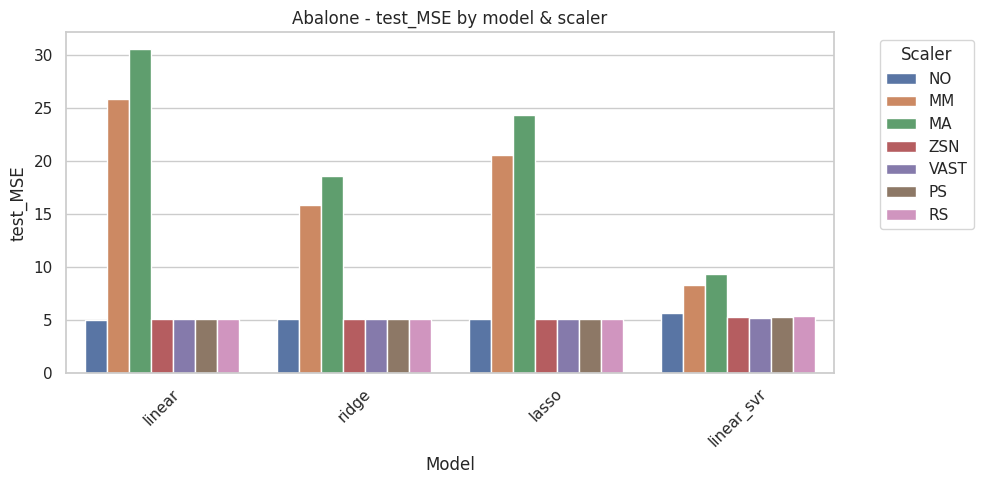

Saved: plots/Abalone_test_MAE.png


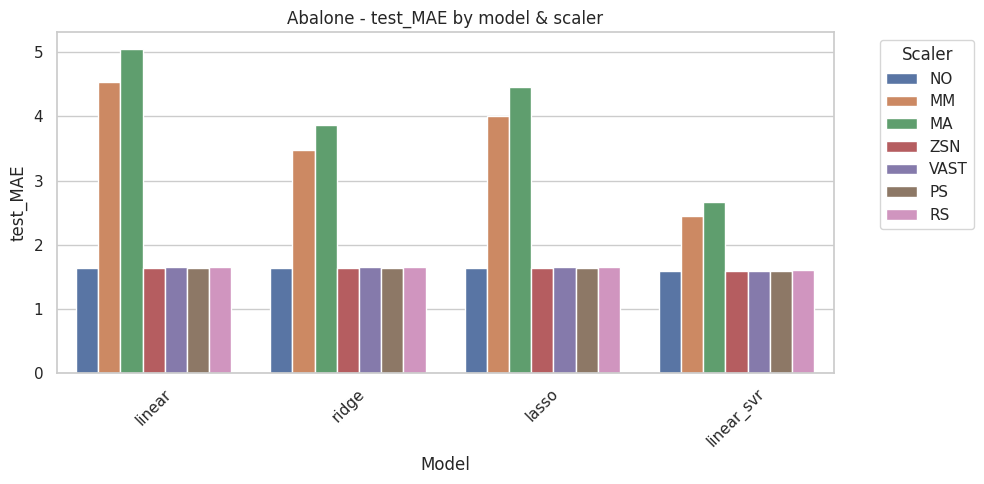

Saved: plots/Abalone_test_R2.png


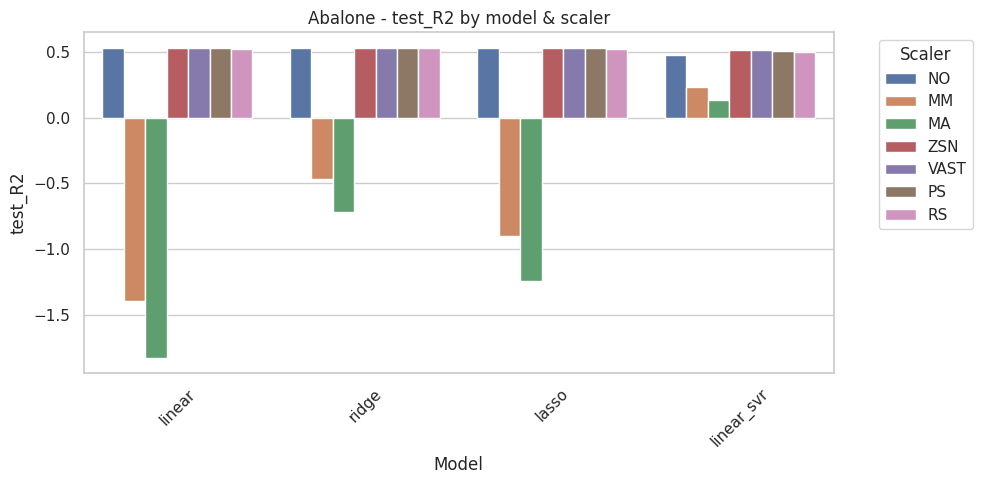

Saved: plots/Abalone_convergence_time.png


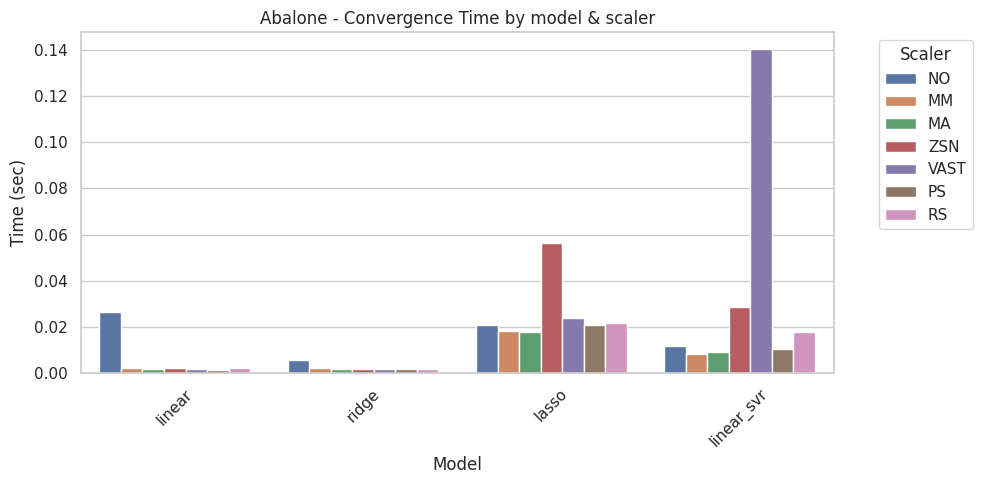


Plotting regression results for: AirQuality
Saved: plots/AirQuality_test_MSE.png


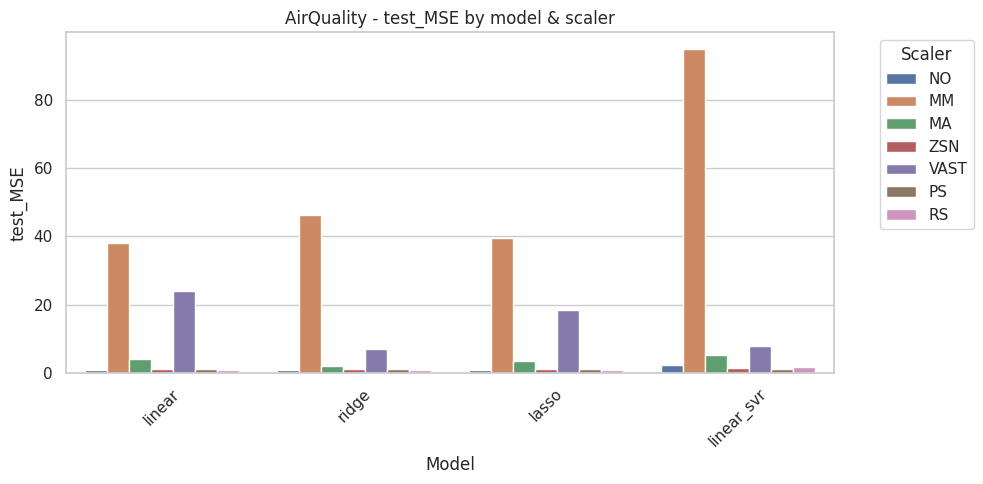

Saved: plots/AirQuality_test_MAE.png


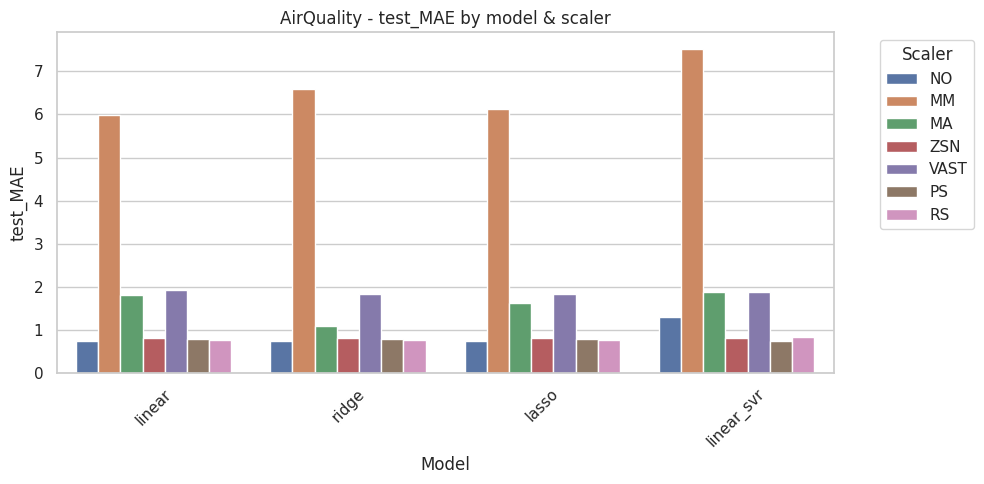

Saved: plots/AirQuality_test_R2.png


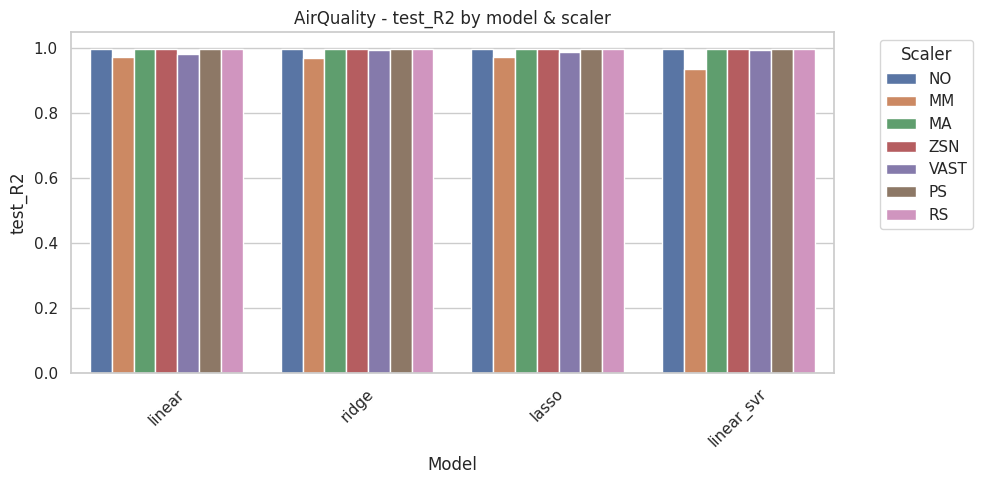

Saved: plots/AirQuality_convergence_time.png


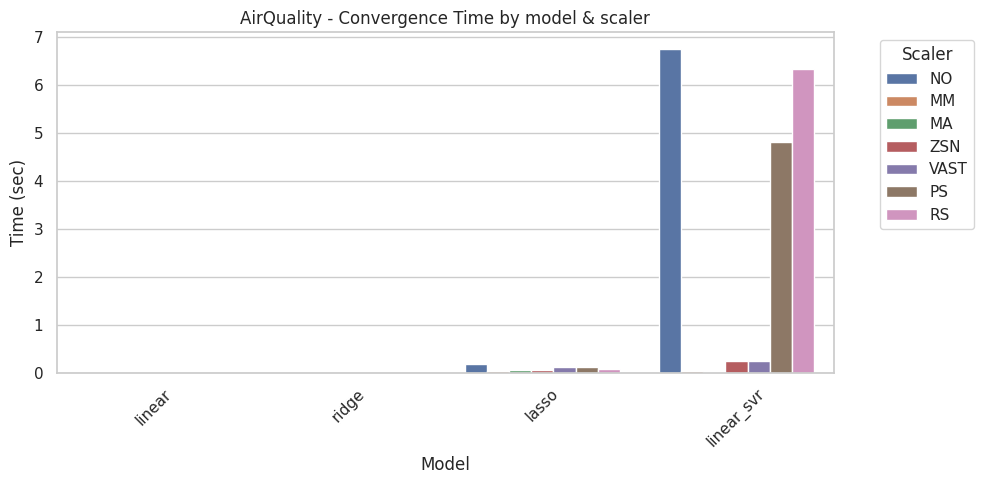


Plotting regression results for: AppliancesEnergy
Saved: plots/AppliancesEnergy_test_MSE.png


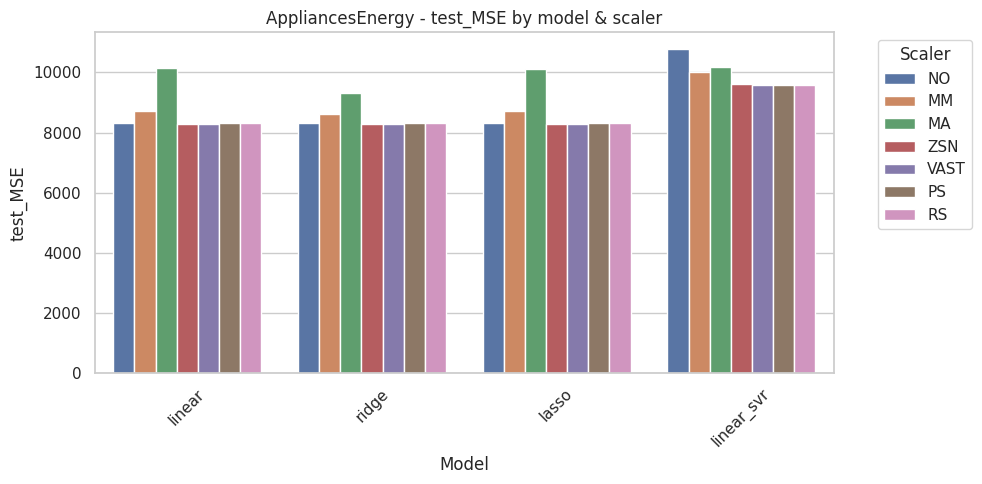

Saved: plots/AppliancesEnergy_test_MAE.png


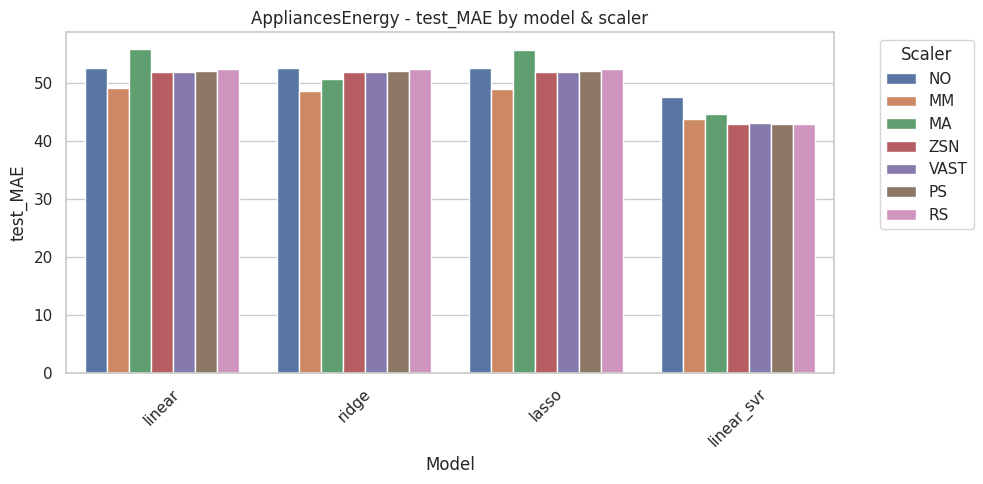

Saved: plots/AppliancesEnergy_test_R2.png


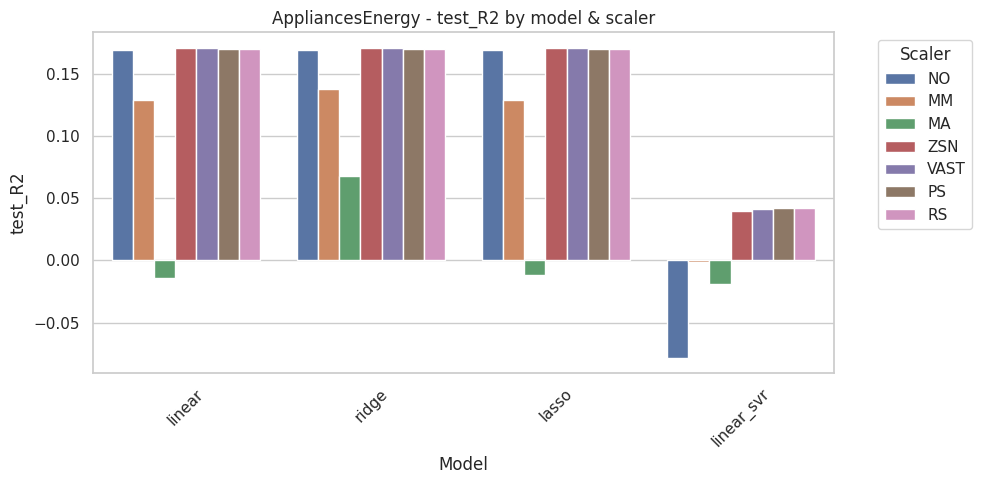

Saved: plots/AppliancesEnergy_convergence_time.png


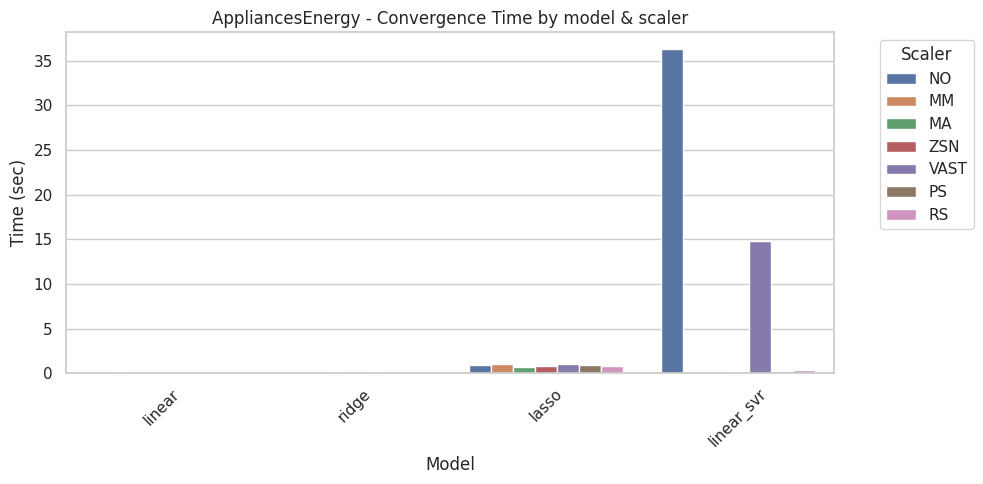


Plotting regression results for: Concrete_CompressiveStrength
Saved: plots/Concrete_CompressiveStrength_test_MSE.png


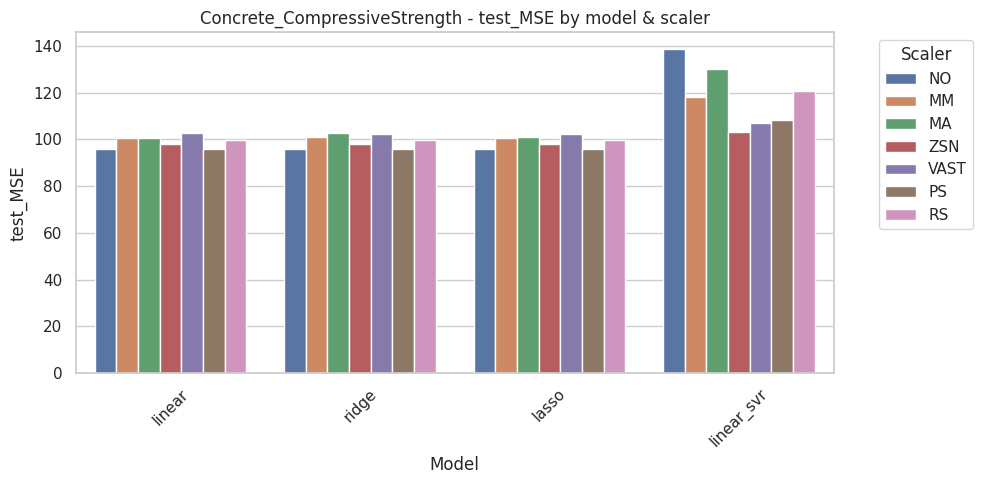

Saved: plots/Concrete_CompressiveStrength_test_MAE.png


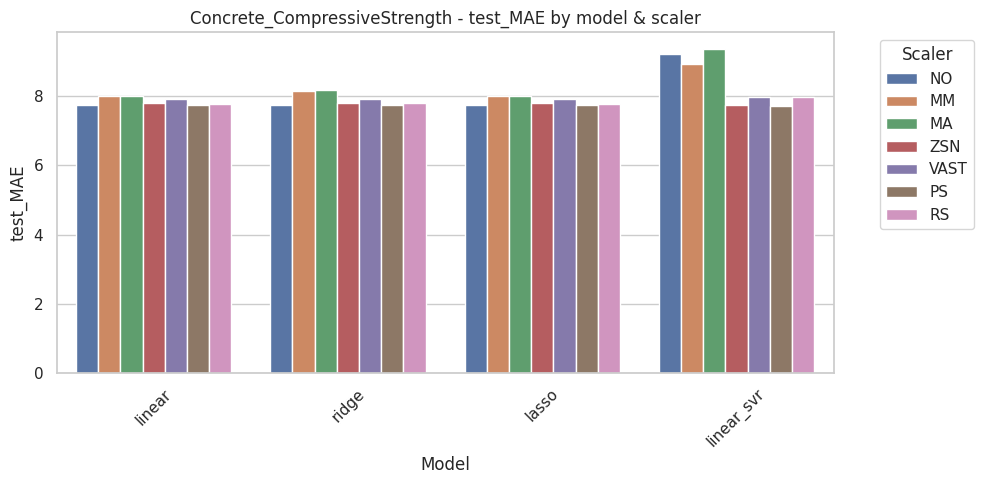

Saved: plots/Concrete_CompressiveStrength_test_R2.png


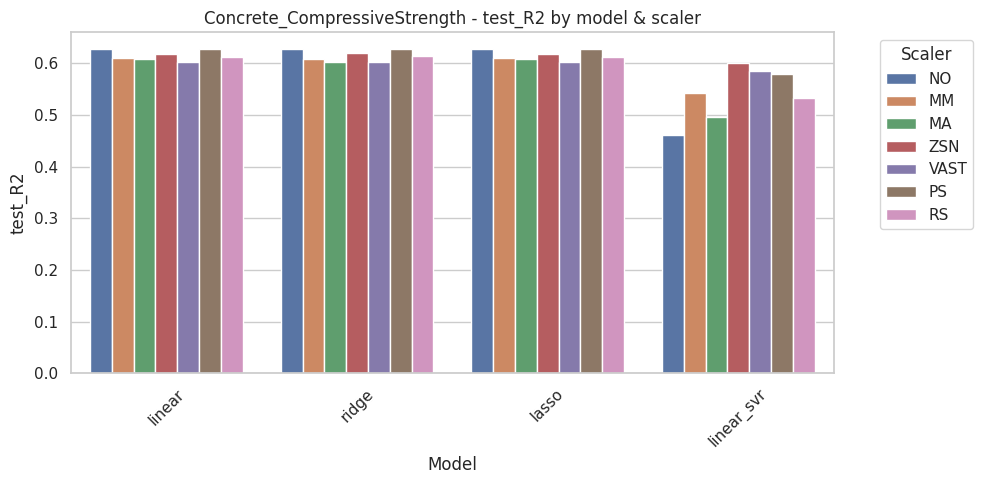

Saved: plots/Concrete_CompressiveStrength_convergence_time.png


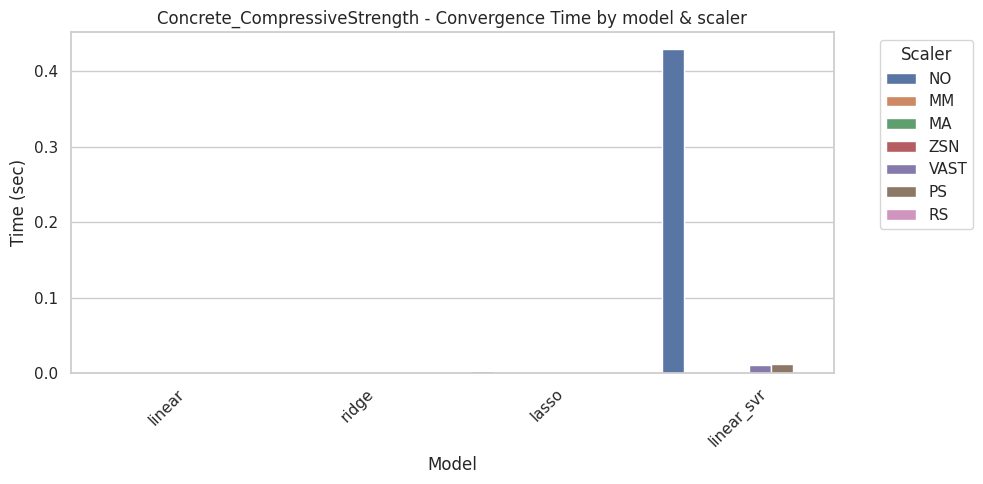


Plotting regression results for: WineQuality
Saved: plots/WineQuality_test_MSE.png


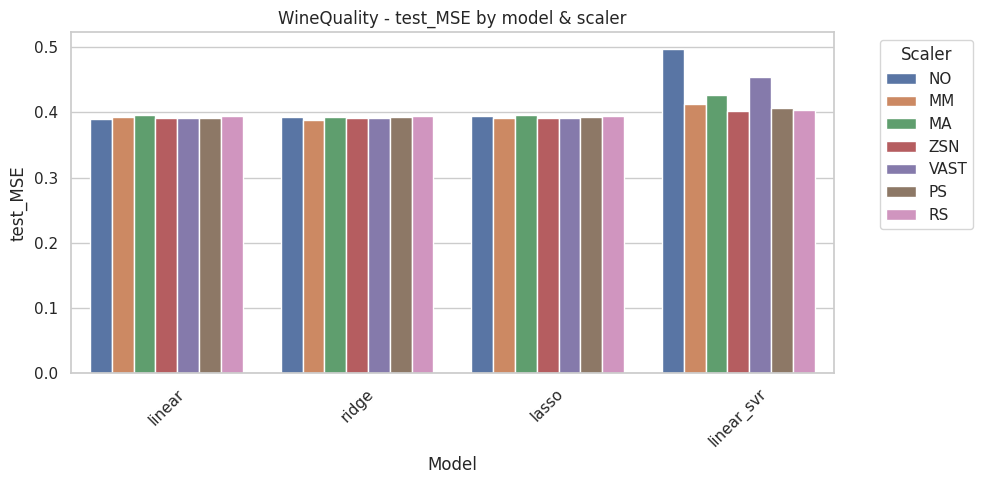

Saved: plots/WineQuality_test_MAE.png


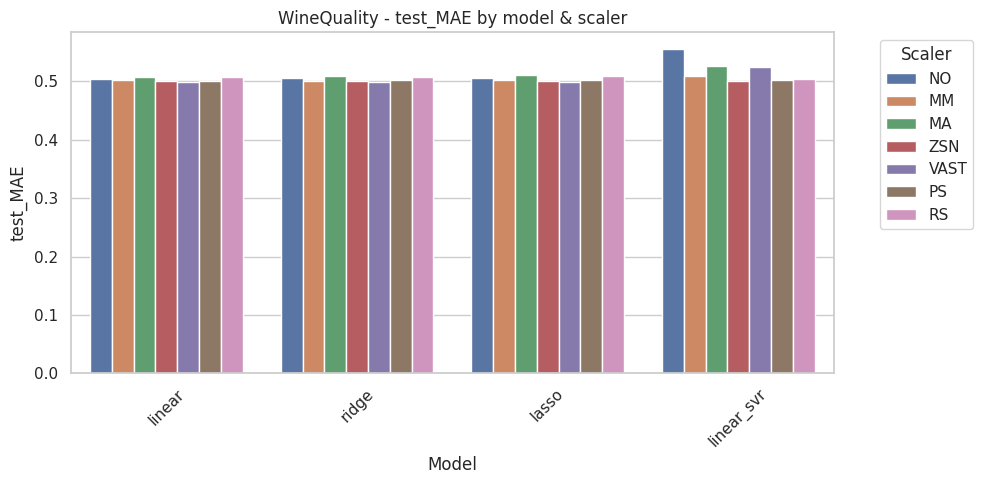

Saved: plots/WineQuality_test_R2.png


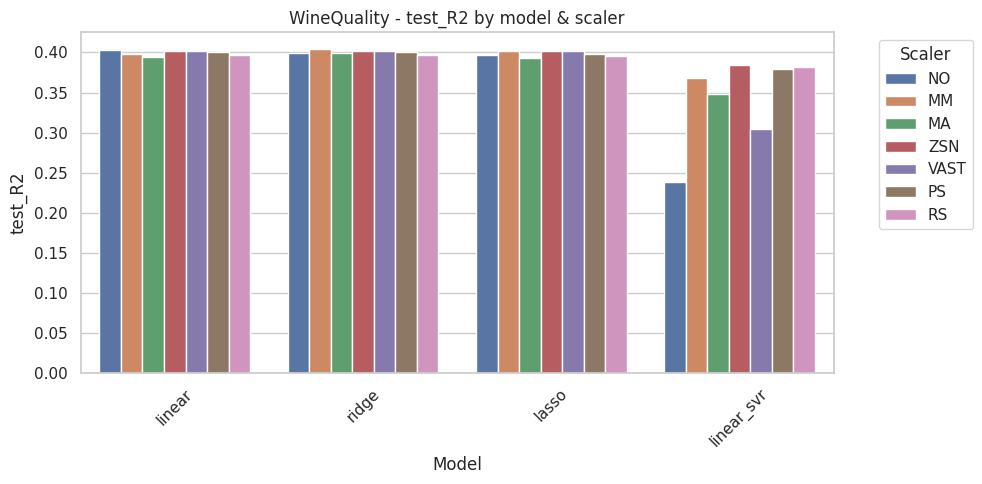

Saved: plots/WineQuality_convergence_time.png


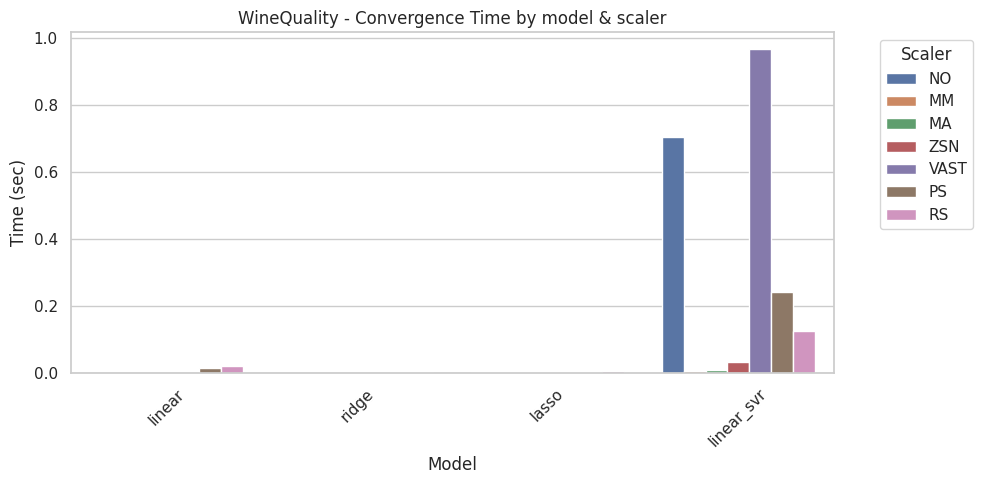


Plotting classification results for: BreastCancer_Diagnostic

Plotting classification results for: HeartDisease_Cleveland

Plotting classification results for: MAGIC_GammaTelescope

Plotting classification results for: Rice_Cammeo_Osmancik


In [ ]:
for ds in reg_dsets.keys():
    print("\nPlotting regression results for:", ds)
    plot_regression_metrics(results, ds)

for ds in class_dsets.keys():
    print("\nPlotting classification results for:", ds)
    plot_classification_metrics(results, ds)

In [12]:
print("\nAggregated summary by dataset and scaler (regression):")
reg_summary = results[results['task']=='regression'].groupby(['dataset','scaler']).agg({
    'test_MSE':'mean','test_MAE':'mean','test_R2':'mean','time_sec':'mean'
}).reset_index().sort_values(['dataset','scaler'])
display(reg_summary)

print("\nAggregated summary by dataset and scaler (classification):")
clf_summary = results[results['task']=='classification'].groupby(['dataset','scaler']).agg({
    'test_acc':'mean','time_sec':'mean'
}).reset_index().sort_values(['dataset','scaler'])
display(clf_summary)

reg_summary.to_csv("regression_summary_by_scalers.csv", index=False)
clf_summary.to_csv("classification_summary_by_scalers.csv", index=False)


Aggregated summary by dataset and scaler (regression):


,dataset,scaler,test_MSE,test_MAE,test_R2,time_sec
0,Abalone,MA,20.736050,4.010975,-0.915550,0.062250
1,Abalone,MM,17.660750,3.617175,-0.631450,0.020050
2,Abalone,NO,5.218875,1.625750,0.517900,0.023975
3,Abalone,PS,5.133725,1.631950,0.525775,0.025125
4,Abalone,RS,5.185100,1.641650,0.521025,0.023075
5,Abalone,VAST,5.122450,1.633350,0.526800,0.090825
6,Abalone,ZSN,5.120775,1.631850,0.526950,0.029775
7,AirQuality,MA,3.696750,1.605175,0.997525,0.024550
8,AirQuality,MM,54.747875,6.558225,0.963375,0.021250
9,AirQuality,NO,1.365075,0.884650,0.999075,4.812050



Aggregated summary by dataset and scaler (classification):


,dataset,scaler,test_acc,time_sec
0,BreastCancer_Diagnostic,MA,0.751467,0.004800
1,BreastCancer_Diagnostic,MM,0.862567,0.009333
2,BreastCancer_Diagnostic,NO,0.909333,0.012100
3,BreastCancer_Diagnostic,PS,0.964900,0.001933
4,BreastCancer_Diagnostic,RS,0.967833,0.002500
5,BreastCancer_Diagnostic,VAST,0.961967,0.006333
6,BreastCancer_Diagnostic,ZSN,0.967833,0.009033
7,HeartDisease_Cleveland,MA,0.500000,0.005367
8,HeartDisease_Cleveland,MM,0.538900,0.005200
9,HeartDisease_Cleveland,NO,0.483333,0.005667


In [13]:
sns.set(style="whitegrid")


def plot_metric_across_datasets(df, metric, task, filename):

    df_task = df[df["task"] == task]
    datasets = df_task["dataset"].unique()
    num_ds = len(datasets)

    fig, axes = plt.subplots(num_ds, 1, figsize=(10, 4*num_ds), sharex=True)

    if num_ds == 1:
        axes = [axes]

    for ax, ds in zip(axes, datasets):
        df_ds = df_task[df_task["dataset"] == ds]

        sns.barplot(
            data=df_ds,
            x="model_kind",
            y=metric,
            hue="scaler",
            ax=ax
        )
        ax.set_title(f"{ds} — {metric}")
        ax.set_xlabel("")
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Scaler",
               loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.02))

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.12)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# REGRESSION METRIC PLOTS

def plot_regression_all(df):
    plot_metric_across_datasets(df, "test_MAE",
                                task="regression",
                                filename="regression_MAE.png")

    plot_metric_across_datasets(df, "test_MSE",
                                task="regression",
                                filename="regression_MSE.png")

    plot_metric_across_datasets(df, "test_R2",
                                task="regression",
                                filename="regression_R2.png")

    plot_metric_across_datasets(df, "time_sec",
                                task="regression",
                                filename="regression_time.png")

# CLASSIFICATION METRIC PLOTS

def plot_classification_all(df):
    plot_metric_across_datasets(df, "test_acc",
                                task="classification",
                                filename="classification_accuracy.png")

    plot_metric_across_datasets(df, "test_f1",
                                task="classification",
                                filename="classification_f1.png")

    plot_metric_across_datasets(df, "time_sec",
                                task="classification",
                                filename="classification_time.png")


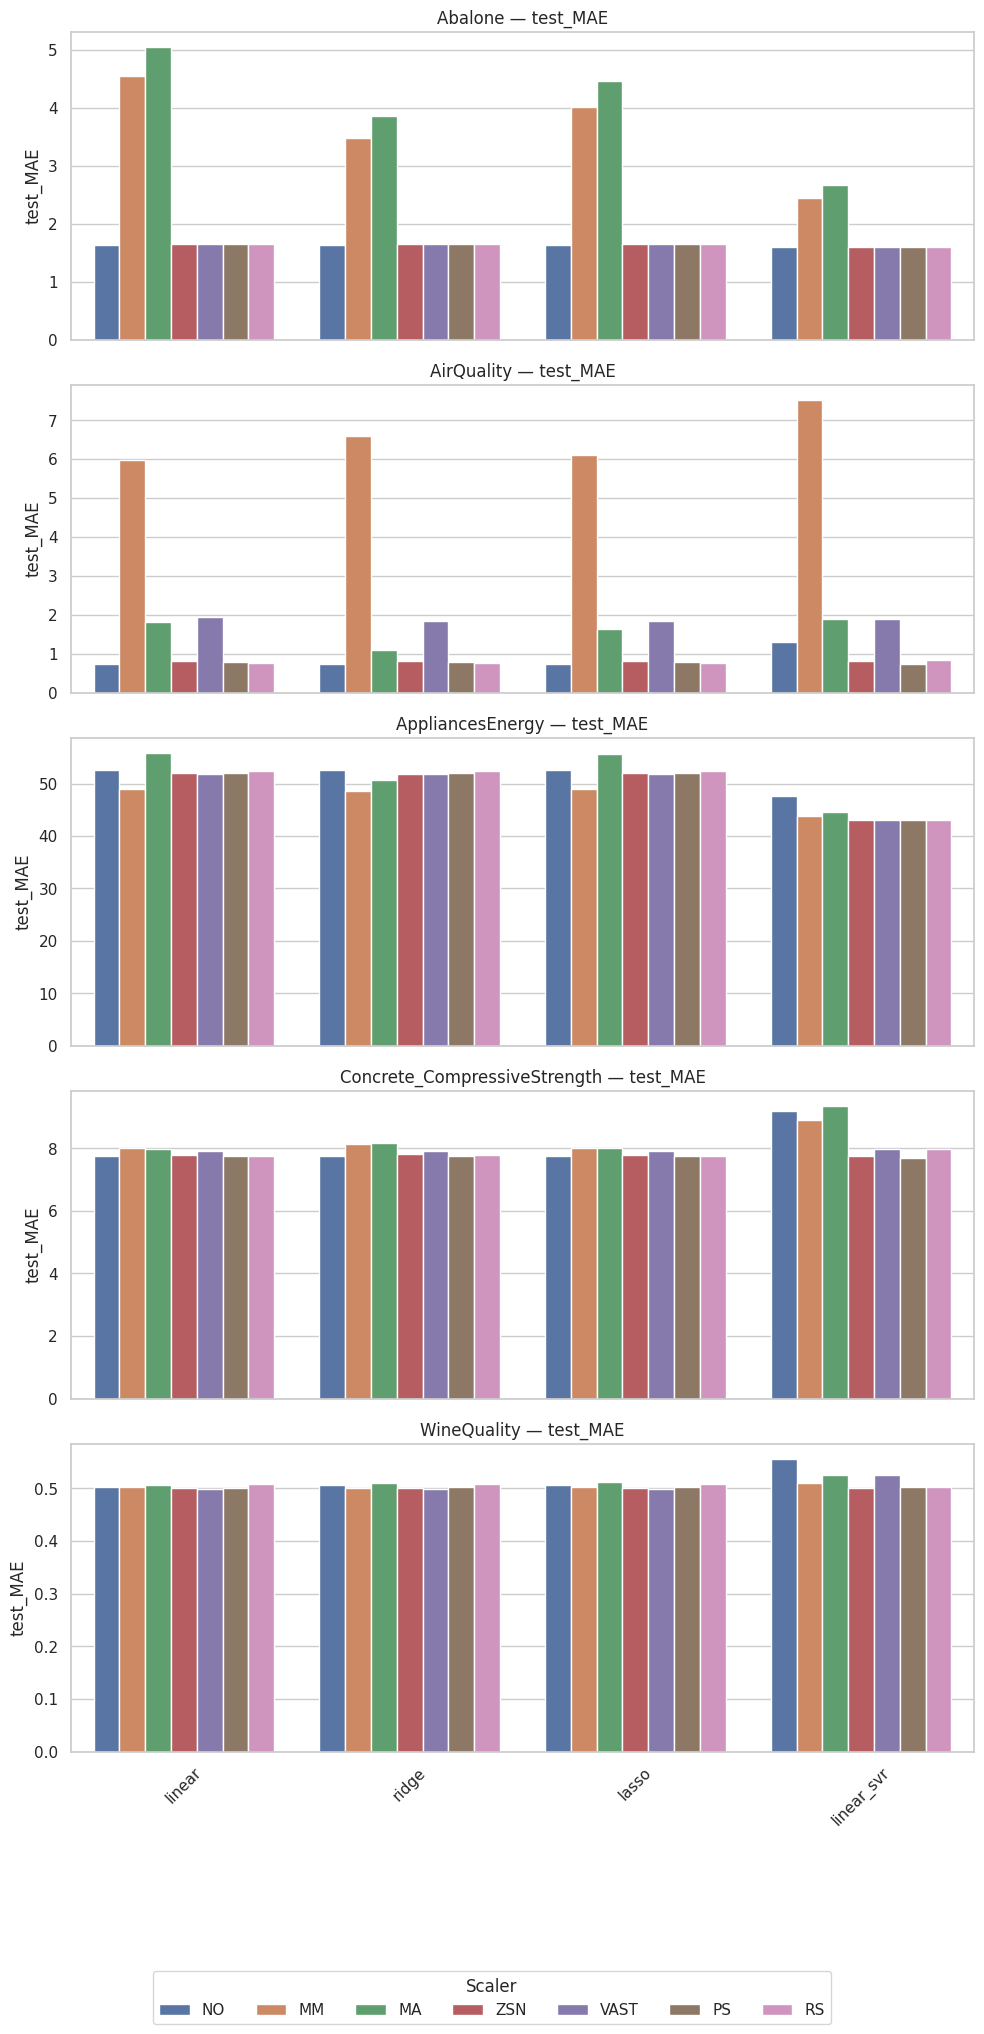

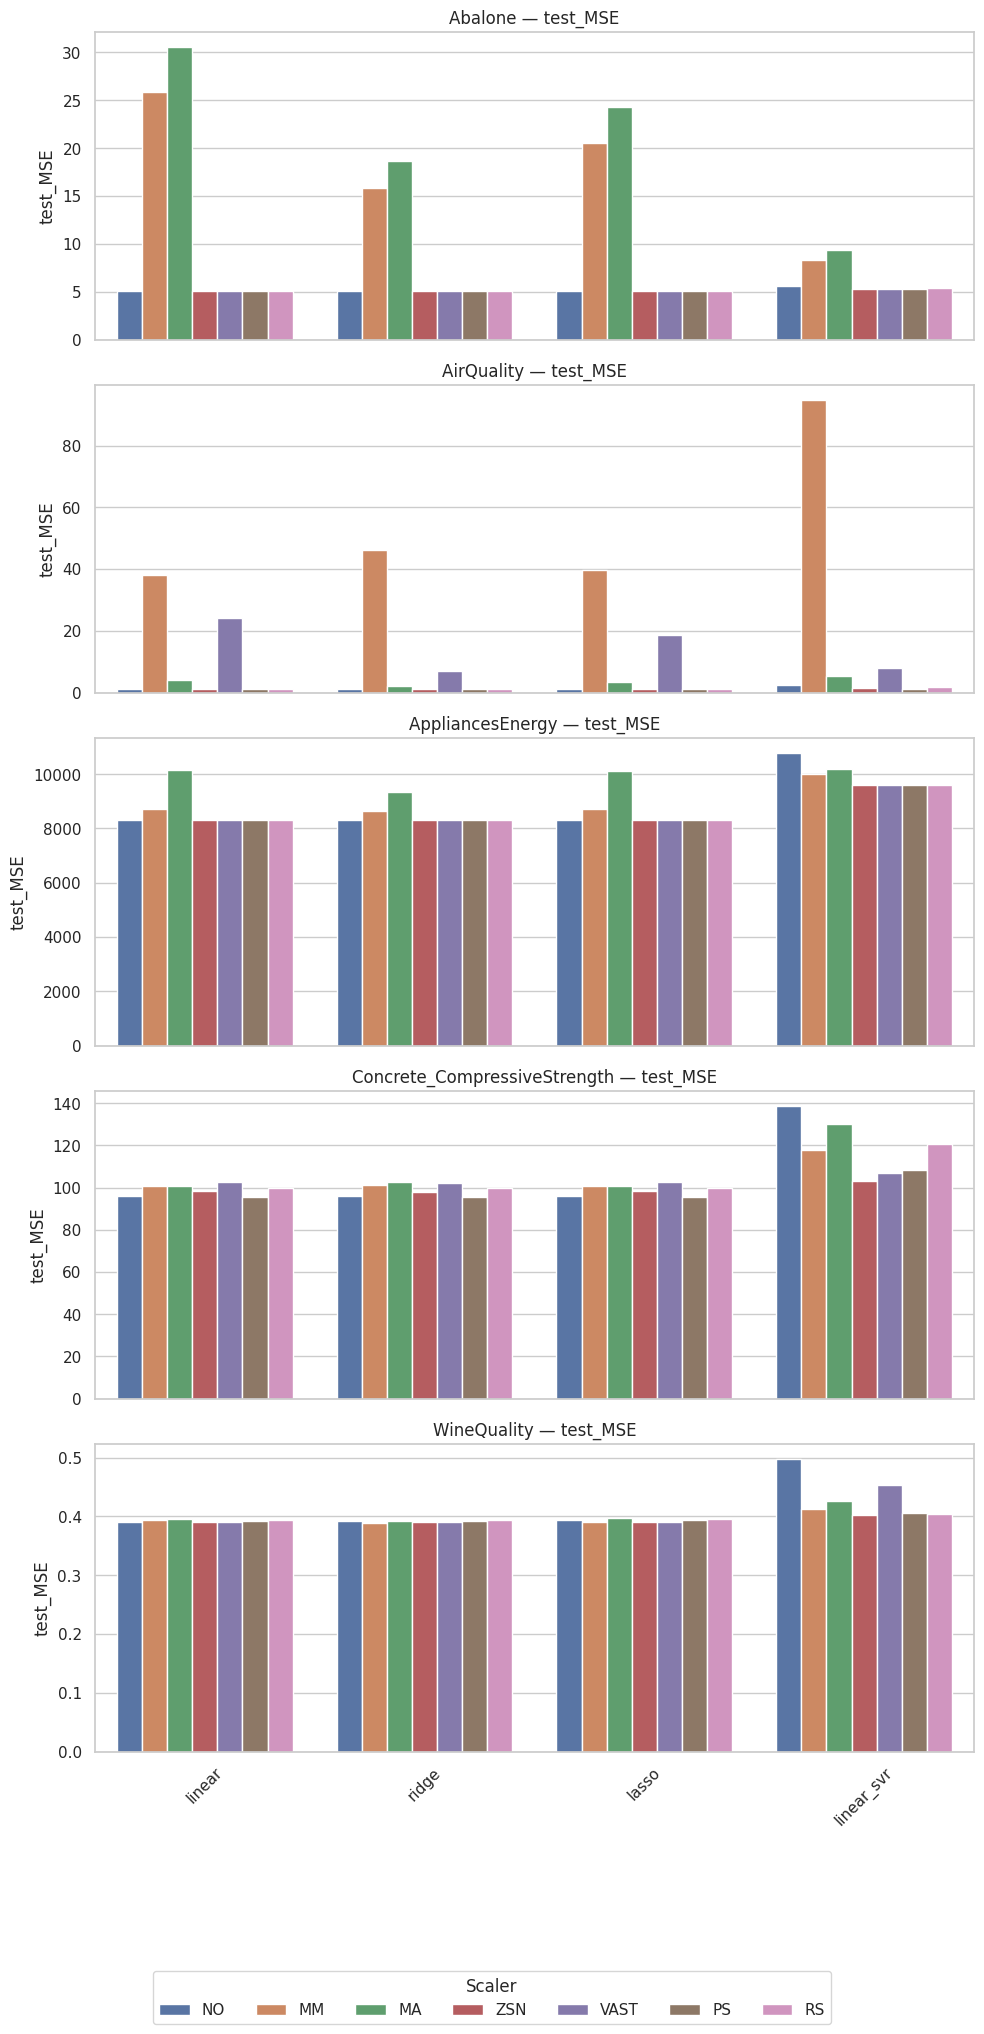

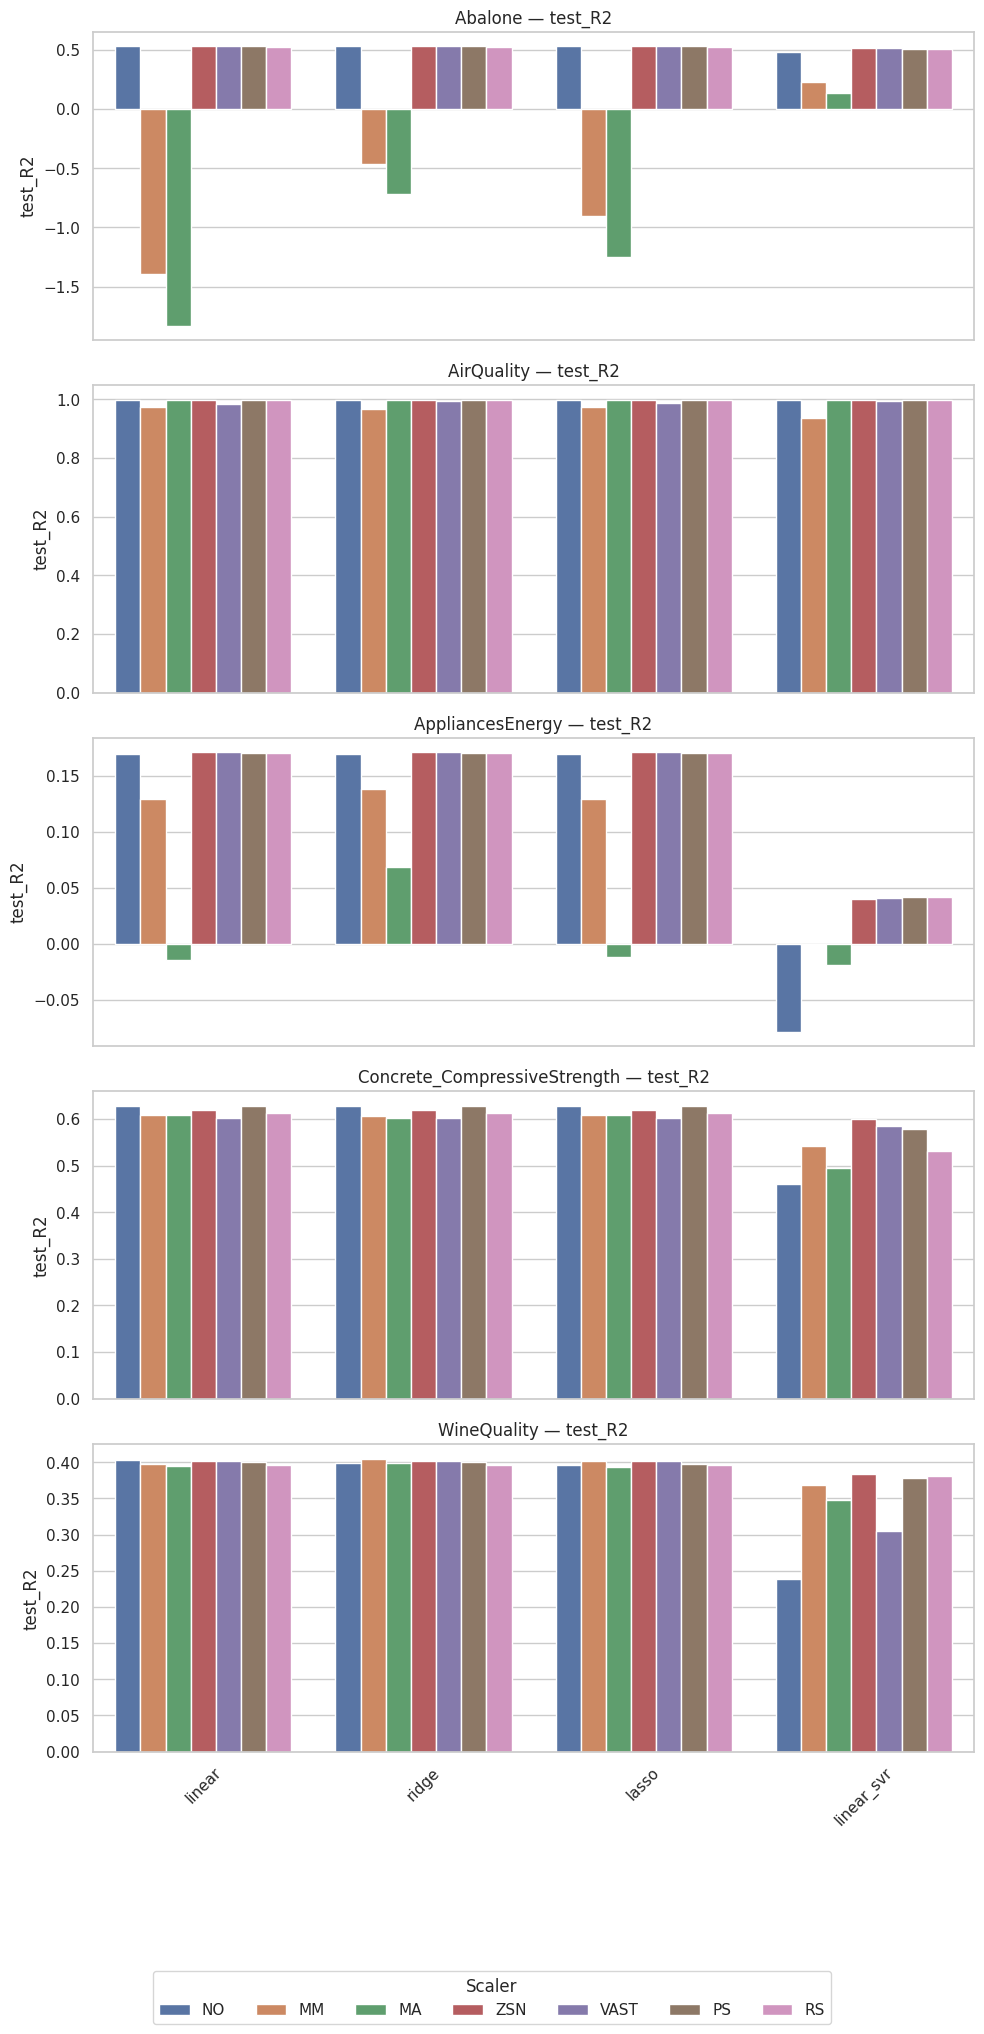

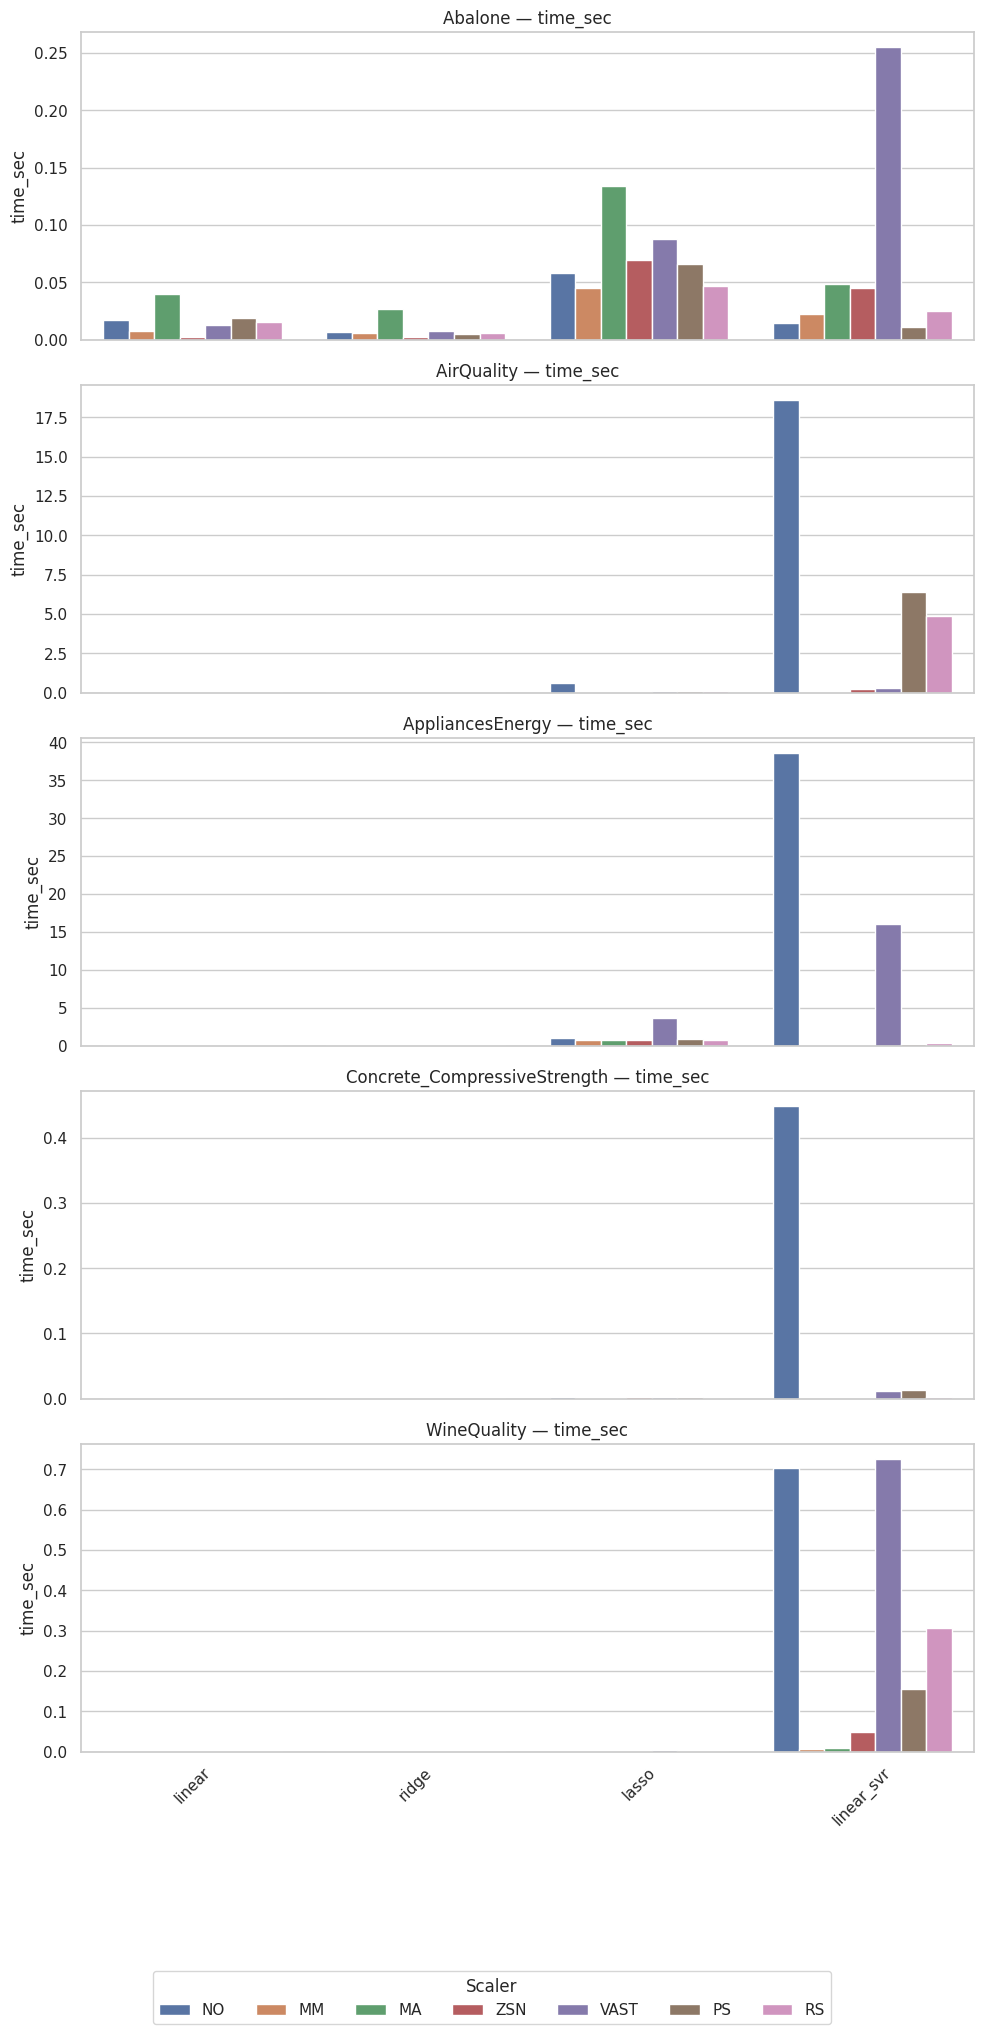

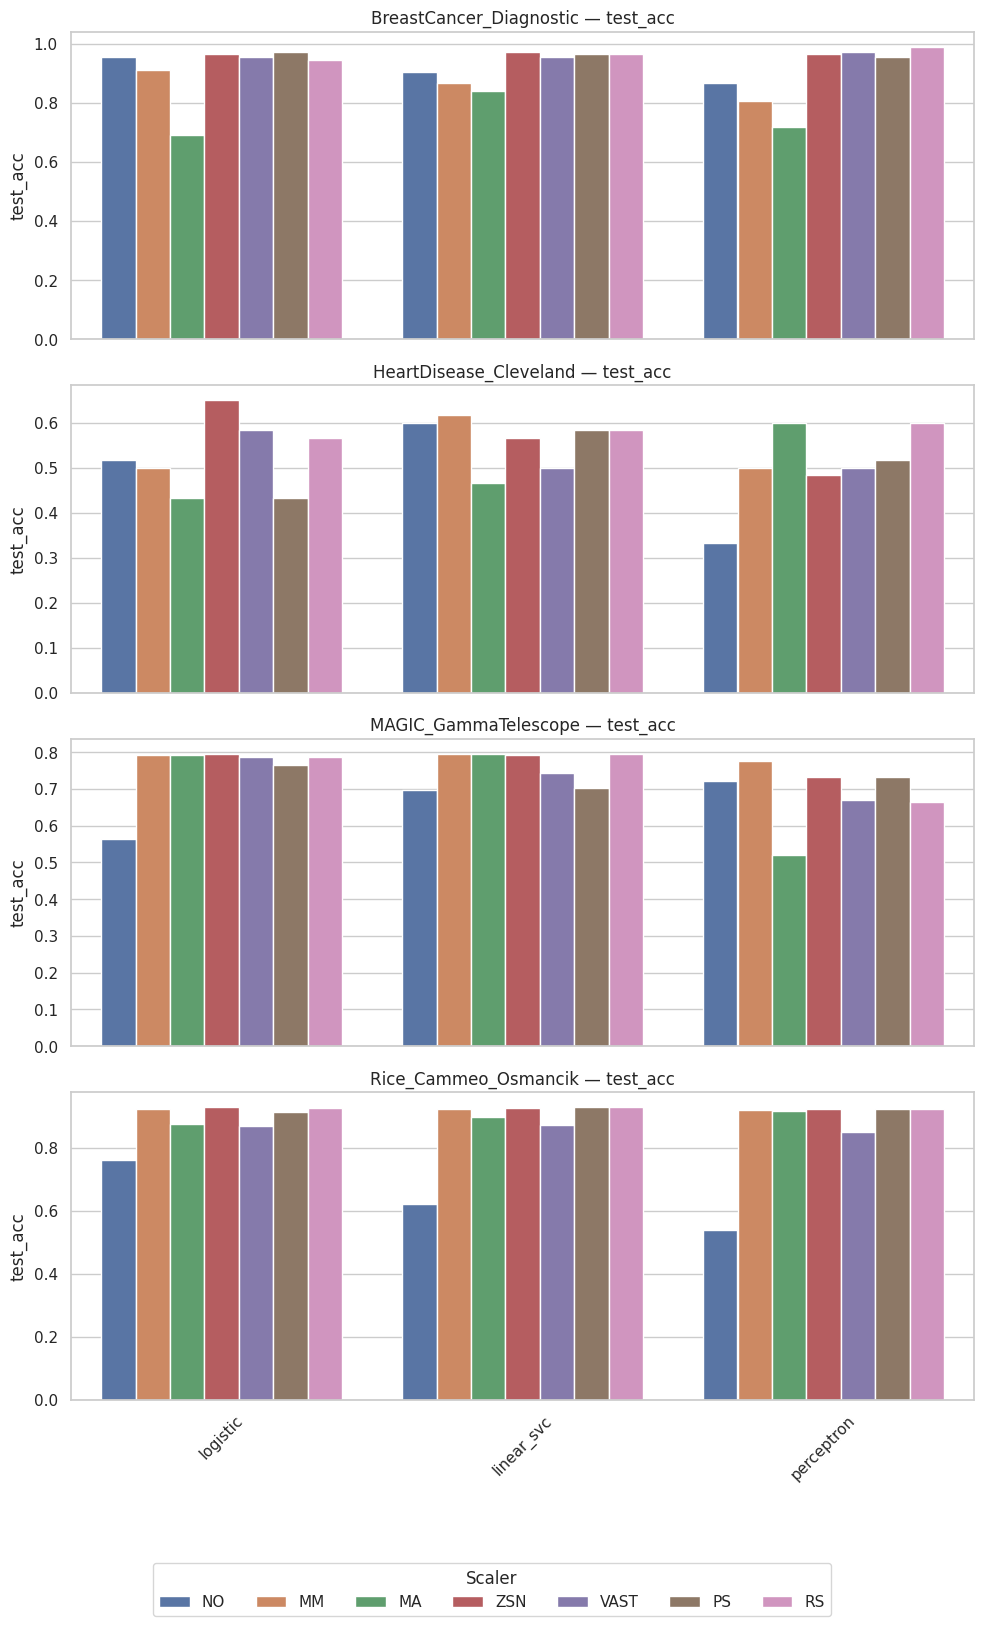

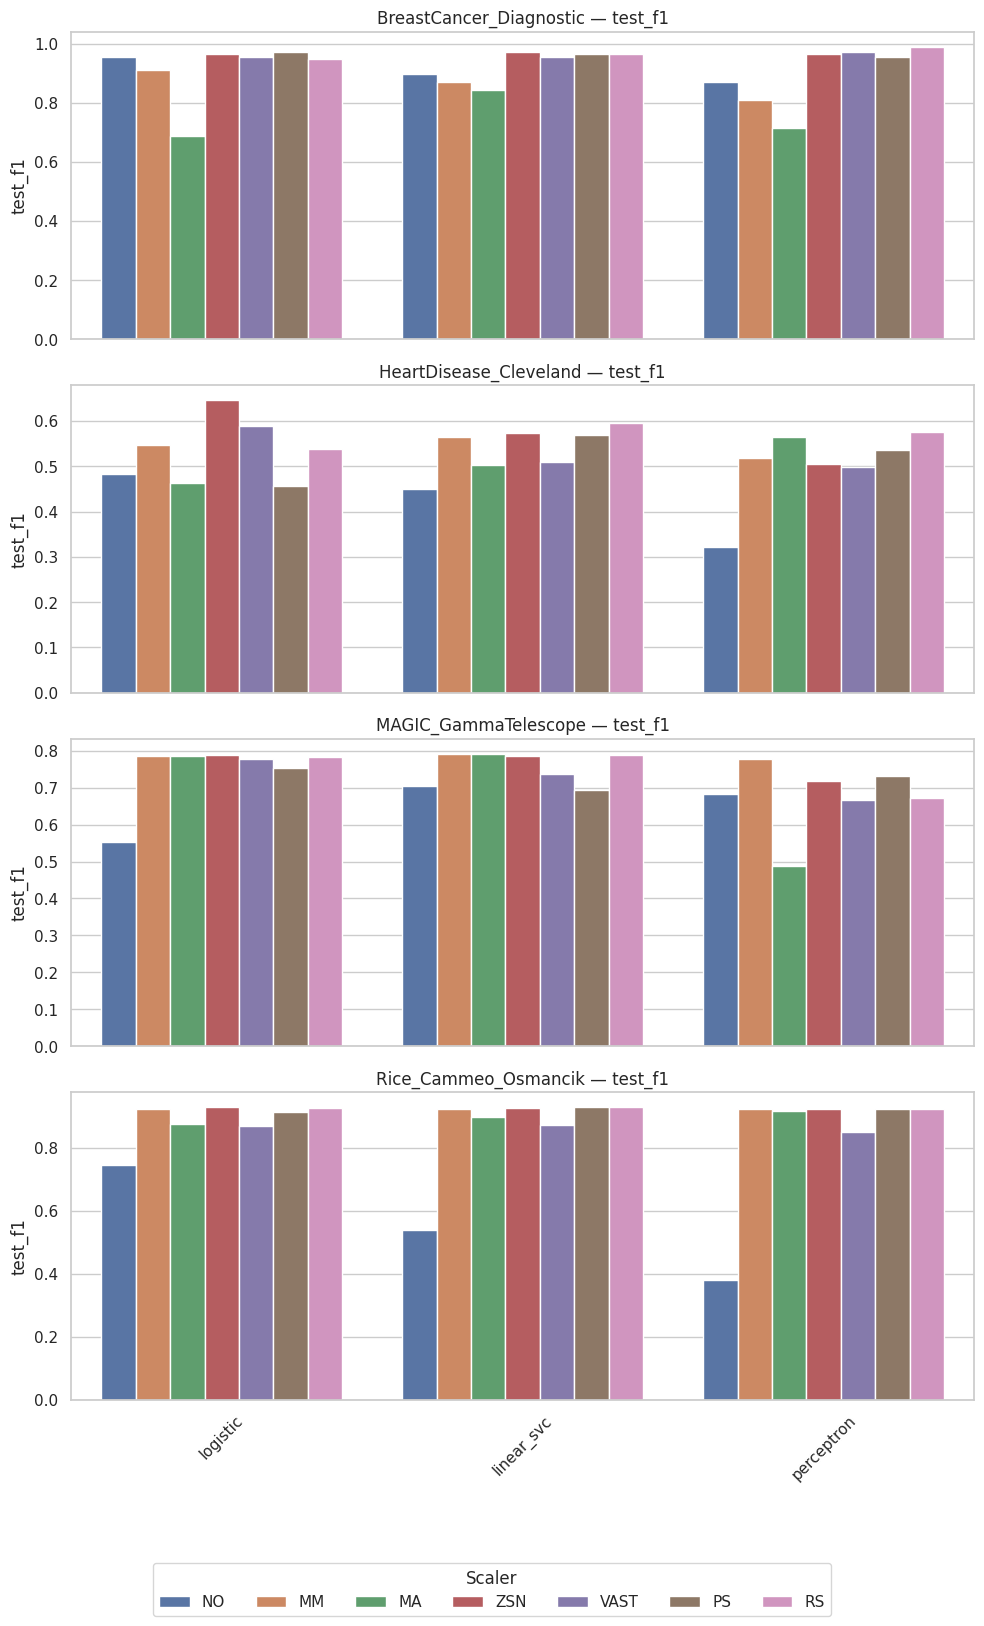

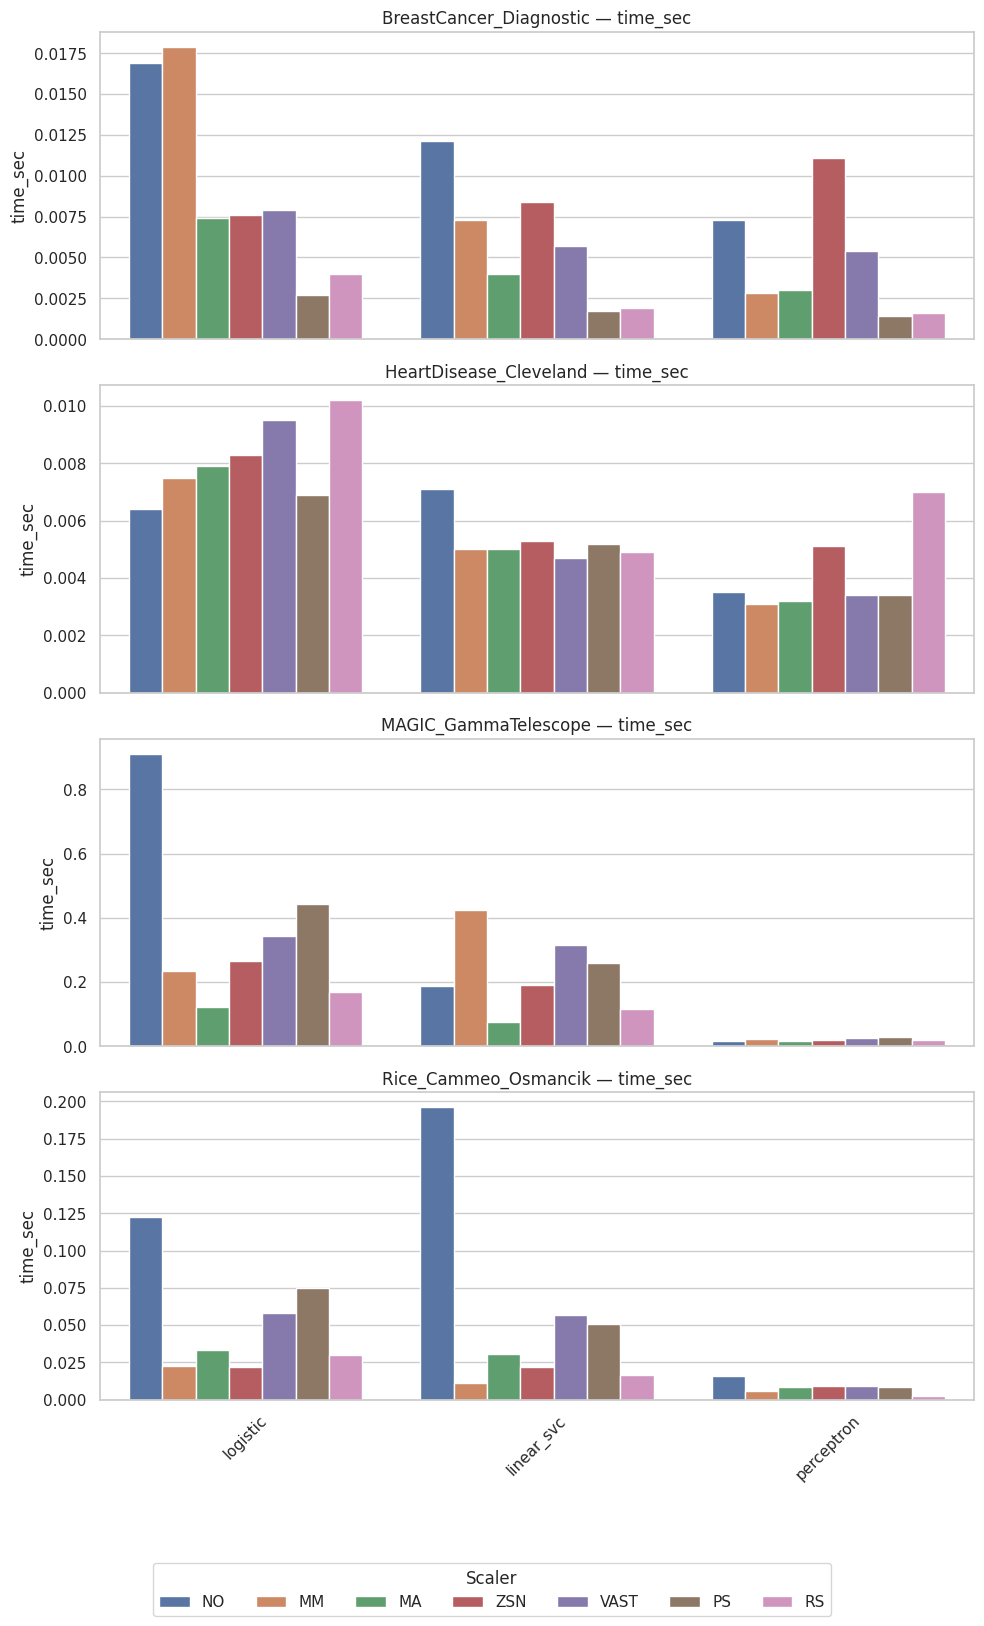

In [14]:
plot_regression_all(results)
plot_classification_all(results)
